# Project: Malaria Cell Image Classification
# Author: Robert Zacchigna

# Table of Contents

* [Problem Statement](#Problem_Statement)
* [Proposal](#Proposal)
* [Dataset - Malaria Cell Image Classification](#Dataset)
    * [Download Location](#Download_Location)
    * [Images](#Images)
* [Imports](#Imports)
* [Definitions](#Definitions)
    * [split_image_folders](#Defs-Split_Images)


* **[Part 1: FastAI CNN Implementation](#Part_1)**
    * [Step 1: Load, Split and Transform Images](#Part_1-Step_1)
        * [Image Dataset Sizes](#Part_1-Step_1-Image_Sizes)
        * [Split Images - Randomly Sample 1/4th of the Images in Each Folder](#Part_1-Step_1-Split_Images)
        * [Randomize, Resize and Transform Images](#Part_1-Step_1-Rand_Rez_Tran_Images)
        * [Display Augmented Images](#Part_1-Step_1-Aug_Images)
    * [Step 2: Build Classification Model Using XResNet34](#Part_1-Step_2)
    * [Step 3: Classification Confusion Matrix](#Part_1-Step_3)
    * [Step 4: Display Model Results](#Part_1-Step_4)
        * [Classification Report](#Part_1-Step_4-Class_Report)
        * [Prediction Results Sample](#Part_1-Step_4-Pred_Samp)
    * [Part 1 Conclusion](#Part_1-Conclusion)


* **[Part 2: Tensorflow/Keras CNN Implementation](#Part_2)**
    * [Step 1: Load, Split and Transform Images](#Part_2-Step_1)
        * [Image Dataset Sizes](#Part_2-Step_1-Image_Sizes)
        * [Split Images - Randomly Sample 1/4th of the Images in Each Folder](#Part_2-Step_1-Split_Images)
        * [Randomize, Resize and Transform Images](#Part_2-Step_1-Rand_Rez_Tran_Images)
        * [Display Augmented Images](#Part_2-Step_1-Aug_Images)
    * [Step 2: Divide Image Dataset into Train and Test Sets](#Part_2-Step_2)
        * [Train Image Generator](#Part_2-Step_2-Train_Gen)
        * [Test Image Generator](#Part_2-Step_2-Test_Gen)
    * [Step 3: Create CNN Model](#Part_2-Step_3)
        * [Model Summary](#Part_2-Step_3-Model_Summ)
        * [Compile Model](#Part_2-Step_3-Model_Comp)
        * [Train Model with Early Stop Loss](#Part_2-Step_3-Model_Train)
    * [Step 4: Model Accuracy and Loss Graphs](#Part_2-Step_4)
        * [Model Accuracy](#Part_2-Step_4-Model_Acc)
        * [Model Loss](#Part_2-Step_4-Model_Loss)
    * [Step 5: Model Predictions](#Part_2-Step_5)
        * [Classification Confusion Matrix](#Part_2-Step_5-Conf_Mat)
    * [Step 6: Display Model Results](#Part_2-Step_6)
        * [Classification Report](#Part_2-Step_6-Class_Report)
        * [Prediction Results Sample](#Part_2-Step_6-Results_Samp)
    * [Part 2 Conclusion](#Part_2-Conclusion)

<a id='Problem_Statement'></a>
## Problem Statement:

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female mosquitoes, it is preventable and curable. Malaria is specifically caused by Plasmodium parasites and are spread to people through the bites of infected female Anopheles mosquitoes, called "malaria vectors." There are five parasite species that cause malaria in humans, and 2 of these species – P. falciparum and P. vivax – pose the greatest threat. 

This is an acute febrile illness and in a non-immune individual, symptoms usually appear 10–15 days after the infective mosquito bite. The first symptoms – fever, headache, and chills – may be mild and difficult to recognize as malaria and if not treated within 24 hours, P. falciparum malaria can progress to severe illness, often leading to death.


<a id='Proposal'></a>
## Proposal:

Create a model that can effectively and accurately identify cells that are infected or uninfected with malaria. I will be utilizing two different image processing/modeling libraries to implement a CNN ([Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network)) model: fastai and tensorflow/keras. These two libraries have great support and should provide the best tools for modeling using these images. This analysis methodology will focus on fine tuning the different models and comparing them across the two libraries to see which one performs the best with the given data.


<a id='Dataset'></a>
## Dataset - Malaria Cell Image Classification

<ins>Download Location:</ins> https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria <a id='Download_Location'></a>

<ins>Image Folders:</ins> <a id='Images'></a>

* __Uninfected__ – Folder containing images of uninfected cells
* __Parasitized__ – Folder containing images of cells infected/parasitized with malaria


<a id='Imports'></a>
## Imports

In [1]:
import os
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd

from notebook import __version__ as nbv

# Pillow Libraries
from PIL import Image
from PIL import __version__ as pilv

# mlxtend Libraries
from mlxtend.plotting import plot_confusion_matrix
from mlxtend import __version__ as mlxv

# matplotlib Libraries
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpv

# FastAI Libraries
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.data import *
from fastai import __version__ as fastv

# Tensorflow/Keras Libraries
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization

# Sklearn Libraries
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import __version__ as skv


# Library Versions
lib_info = [('cv2', cv2.__version__), ('numpy', np.__version__), ('fastai', fastv), ('pandas', pd.__version__),
             ('sklearn', skv), ('mlxtend', mlxv), ('PIL/Pillow', pilv), ('matplotlib', mpv), 
            ('tensorflow/keras', tf.__version__), ('Jupyter Notebook (notebook)', nbv)]

print('Library Versions\n' + '='*16)

for name, vers in lib_info:
    print('{:>27} = {}'.format(name, vers))

Library Versions
                        cv2 = 4.5.4-dev
                      numpy = 1.19.5
                     fastai = 2.5.3
                     pandas = 1.3.3
                    sklearn = 0.23.2
                    mlxtend = 0.19.0
                 PIL/Pillow = 8.1.0
                 matplotlib = 3.3.4
           tensorflow/keras = 2.4.1
Jupyter Notebook (notebook) = 6.4.5


<a id='Definitions'></a>
## Definitions

<a id='Defs-Split_Images'></a>
### split_image_folders

This function will randomly split the number images in both folders based on the input.
> **Example:** split = 4, per folder: new_total_images = total_images / 4

In [2]:
def split_image_folders(cell_image_dir, split_cell_image_dir, split):
    for fold in os.listdir(cell_image_dir)[-2:]:
        
        split_fold = os.path.join(split_cell_image_dir, fold)

        if not os.path.isdir(split_fold):
            os.makedirs(split_fold)
            
        # Random sample of each of the image folders
        image_list = next(os.walk(os.path.join(cell_image_dir, fold)))[2]
        random_image_files = random.sample(image_list, int(len(image_list)/split))
        
        for file in random_image_files:
            shutil.copy(os.path.join(os.path.join(cell_image_dir, fold), file), split_fold)

    print('Split Cell Image Folders\n' + '='*24)

    for fold in os.listdir(split_cell_image_dir):
        print('{:>11}: {:,} images'.format(fold, len(next(os.walk(os.path.join(split_cell_image_dir, fold)))[2])))

<a id='Part_1'></a>
# Part 1: FastAI CNN Implementation

This section will be building a CNN model using the FastAI library on a subset of the image dataset.

<a id='Part_1-Step_1'></a>
## Step 1: Load, Split and Transform Images

<a id='Part_1-Step_1-Image_Sizes'></a>
### Image Dataset Sizes

In [2]:
print('Cell Image Folders\n' + '='*18)

for fold in os.listdir('Cell_Images/')[-2:]:
    print('{:>11}: {:,} images'.format(fold, len(next(os.walk('Cell_Images/' + fold + '/'))[2])))

Cell Image Folders
Parasitized: 13,780 images
 Uninfected: 13,780 images


<a id='Part_1-Step_1-Split_Images'></a>
### Split Images - Randomly Sample 1/4th of the Images in Each Folder

Due to the computational limitations of my machine, I am unable to train models using the entire image dataset if I want modeling to finish in a reasonable amount of time....and not blow up my computer.

In [3]:
seed = 42
random.seed(seed)

cell_image_dir = os.path.join(os.getcwd(), 'Cell_Images')
split_cell_image_dir = os.path.join(os.getcwd(), 'Split_Cell_Images')

**NOTE:** The below cell isn't necessary and can be skipped if you have a reasonably powerful computer and/or have [CUDA](https://developer.nvidia.com/cuda-toolkit) installed on your machine

See function here: [split_image_folders](#Defs-Split_Images)

In [4]:
split_image_folders(cell_image_dir, split_cell_image_dir, 4)

Split Cell Image Folders
Parasitized: 3,445 images
 Uninfected: 3,445 images


<a id='Part_1-Step_1-Rand_Rez_Tran_Images'></a>
### Randomize, Resize and Transform Images

> **NOTE:** Change `split_cell_image_dir` to `cell_image_dir` if you skipped the previous cell (spitting the image folders)

In [4]:
batch_tfms=[*aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0), Normalize.from_stats(*imagenet_stats)]

image_block = DataBlock(blocks=[ImageBlock, CategoryBlock],
                        get_items=get_image_files,
                        get_y=parent_label,
                        splitter=RandomSplitter(seed=seed),
                        item_tfms=[Resize(224)],
                        batch_tfms=batch_tfms)

# Change 'half_cell_image_dir' to 'cell_image_dir' 
# if you skipped spitting the image folders in half
image_data = image_block.dataloaders(split_cell_image_dir, bs=64)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


<a id='Part_1-Step_1-Aug_Images'></a>
### Display Augmented Images

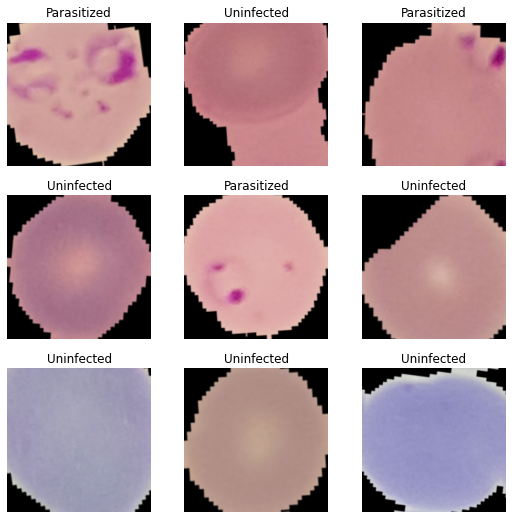

In [5]:
image_data.show_batch()

<a id='Part_1-Step_2'></a>
## Step 2: Build Classification Model Using XResNet34

In [7]:
warnings.filterwarnings("ignore", category=UserWarning)

learn = cnn_learner(image_data, xresnet34, metrics=[accuracy]).to_fp16()
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.623762,0.376479,0.856209,23:40


epoch,train_loss,valid_loss,accuracy,time
0,0.411902,0.283301,0.893972,29:51
1,0.347253,0.206429,0.936819,30:08
2,0.291731,0.215433,0.933188,31:43
3,0.261580,0.181259,0.936093,31:48
4,0.236109,0.172862,0.942629,31:15


The final fine-tuned model ends up with an accuracy of ~0.94, with a loss of 0.17, after 5 epochs and ~3 hrs of runtime. Very good results, especially considering the massively reduced amount of images I had to use for modeling.

### Save Model

In [9]:
learn.save('FastAI_Model/Model-1')

Path('models/Model-1.pth')

<a id='Part_1-Step_3'></a>
## Step 3: Classification Confusion Matrix

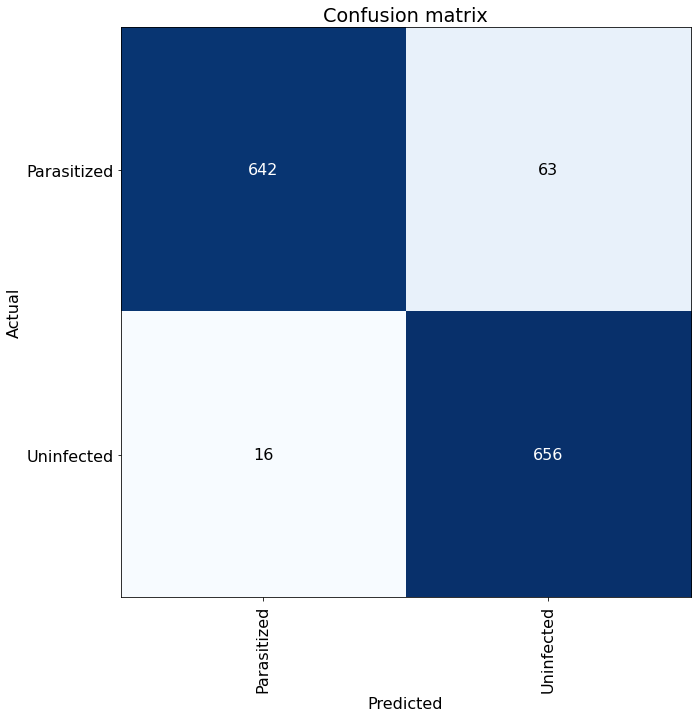

In [11]:
plt.rcParams.update({'font.size': 16})

ClassificationInterpretation.from_learner(learn).plot_confusion_matrix(figsize=(15, 10))

From the matrix above we can see that the model predictions were very good and made relatively few mistakes. The model incorrectly identified 63 Uninfected cells as Parasitized and 16 Parasitized cells as Uninfected.

<a id='Part_1-Step_4'></a>
## Step 4: Display Model Results

<a id='Part_1-Step_4-Class_Report'></a>
### Classification Report

In [13]:
preds, y_true = learn.get_preds()
preds = np.argmax(preds.numpy(), axis=-1)

print(classification_report(y_true.numpy(), preds, target_names=list(image_data.vocab)))

              precision    recall  f1-score   support

 Parasitized       0.98      0.91      0.94       705
  Uninfected       0.91      0.98      0.94       672

    accuracy                           0.94      1377
   macro avg       0.94      0.94      0.94      1377
weighted avg       0.94      0.94      0.94      1377



<a id='Part_1-Step_4-Pred_Samp'></a>
### Prediction Results Sample

Sample of prediction results of the trained model.

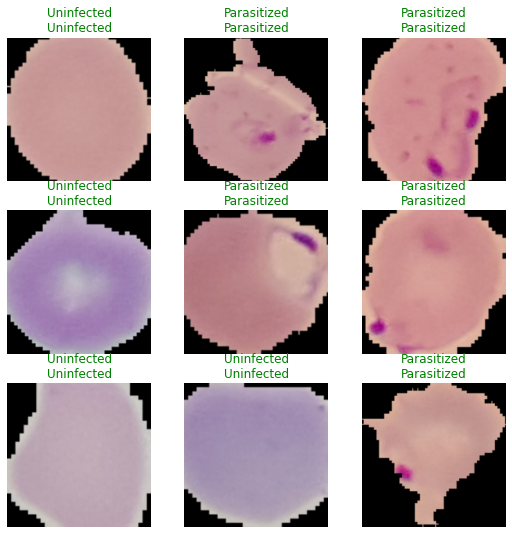

In [15]:
plt.rcParams.update({'font.size': 10})

learn.show_results()

<a id='Part_1-Conclusion'></a>
## Part 1 Conclusion

Even though I had to severely reduce the number of images for training, the model still performed very well with an accuracy score of `~0.94`. The length of the modeling (~3 hrs) for the amount of images is far longer than i would have liked but my computer is currently just not up to spec, having a more powerful GPU and [CUDA](https://developer.nvidia.com/cuda-toolkit) installed will *greatly* speed up the modeling process. `Fastai` definitely makes it very easy to use and does a lot of the groundwork for you, I am definitely quite please with the results and the library as a whole. 

Now we can move onto to making a CNN model from scratch using `Tensorflow/Keras` and see how it compares to the Fastai model.

See [Part 2 Conclusion](#Part_2-Conclusion)

<a id='Part_2'></a>
# Part 2: Tensorflow/Keras CNN Implementation

This section will be building a CNN model using Tensorflow/Keras library on a subset of the image dataset.

> **NOTE:** You can skip to [Randomize, Resize and Transform Images](#Part_2-Step_1-Rand_Rez_Tran_Images) if you don't need to split the dataset or you already ran the dataset split cells in [Part 1: FastAI CNN Implementation](#Part_1)

<a id='Part_2-Step_1'></a>
## Step 1: Load, Split and Transform Images

<a id='Part_2-Step_1-Image_Sizes'></a>
### Image Dataset Sizes

In [2]:
print('Cell Image Folders\n' + '='*18)

for fold in os.listdir('Cell_Images/')[-2:]:
    print('{:>11}: {:,} images'.format(fold, len(next(os.walk('Cell_Images/' + fold + '/'))[2])))

Cell Image Folders
Parasitized: 13,780 images
 Uninfected: 13,780 images


<a id='Part_2-Step_1-Split_Images'></a>
### Split Images - Randomly Sample 1/4th of the Images in Each Folder

Due to the computational limitations of my machine, I am unable to train models using the entire image dataset if I want modeling to finish in a reasonable amount of time....and not blow up my computer.

In [3]:
seed = 42
random.seed(seed)

cell_image_dir = os.path.join(os.getcwd(), 'Cell_Images')
split_cell_image_dir = os.path.join(os.getcwd(), 'Split_Cell_Images')

**NOTE:** The below cell isn't necessary and can be skipped if you have a reasonably powerful computer and/or have [CUDA](https://developer.nvidia.com/cuda-toolkit) installed on your machine

In [4]:
split_image_folders(cell_image_dir, split_cell_image_dir, 4)

Split Cell Image Folders
Parasitized: 3,445 images
 Uninfected: 3,445 images


<a id='Part_2-Step_1-Rand_Rez_Tran_Images'></a>
### Randomize, Resize and Transform Images

> **NOTE:** Change `split_cell_image_dir` to `cell_image_dir` if you skipped the previous cell (spitting the image folders)

In [4]:
data = []
labels = []

for fold in os.listdir(split_cell_image_dir):
    img_fold = os.path.join(split_cell_image_dir, fold)
    image_list = next(os.walk(img_fold))[2]
    
    for img in image_list:
        try:
            image = cv2.imread(os.path.join(img_fold, img))
            image_array = Image.fromarray(image, 'RGB')

            resize_img = image_array.resize((128, 128))
            rotated45 = resize_img.rotate(45)
            rotated75 = resize_img.rotate(75)

            data.append(np.array(resize_img))
            data.append(np.array(rotated45))
            data.append(np.array(rotated75))
            
        except AttributeError:
            pass
        
        if fold == 'Parasitized':
            try:
                blur = cv2.blur(np.array(resize_img), (10, 10))
                data.append(np.array(blur))
                
                labels.append(1)
                labels.append(1)
                labels.append(1)
                labels.append(1)
                
            except AttributeError:
                pass
    
        if fold == 'Uninfected':
            labels.append(0)
            labels.append(0)
            labels.append(0)

cells = np.array(data)
labels = np.array(labels)

<a id='Part_2-Step_1-Aug_Images'></a>
### Display Augmented Images

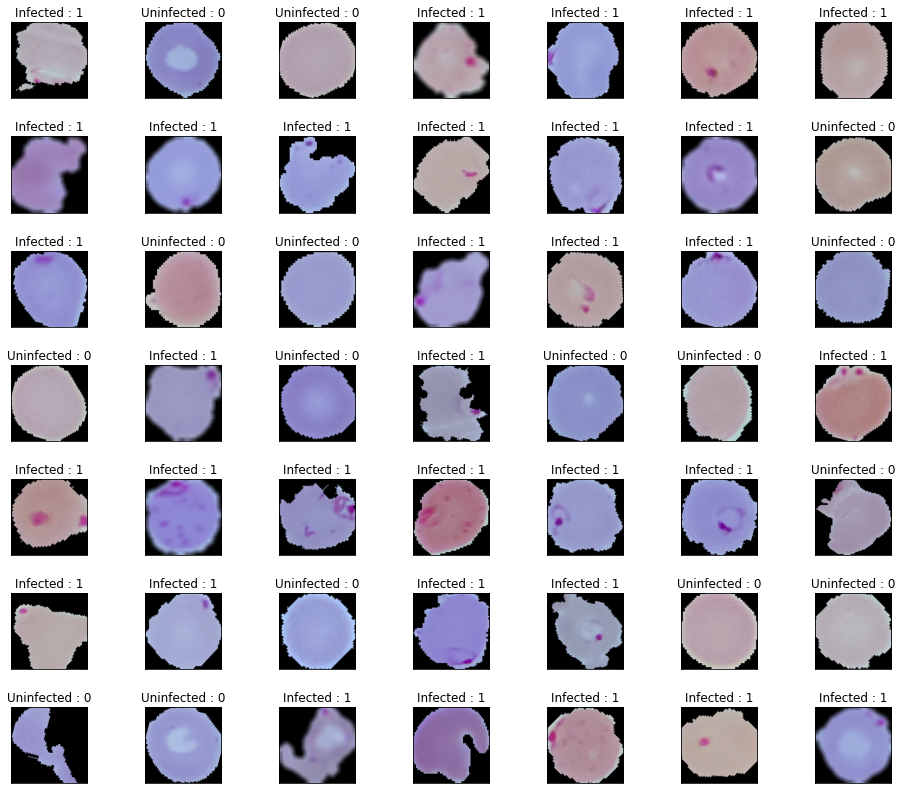

In [77]:
plt.rcParams['figure.figsize'] = (16, 14)
plt.rcParams.update({'font.size': 10})

rand_cells = []
rand_labels = []

for i in range(49):
    r = np.random.randint(0, cells.shape[0], 1)
    
    rand_cells.append(r[0])
    rand_labels.append(labels[r[0]])
    
    plt.subplot(7, 7, i + 1)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Uninfected', labels[r[0]]))
    
    plt.xticks([])
    plt.yticks([])
    
plt.show()

<a id='Part_2-Step_2'></a>
## Step 2: Divide Image Dataset into Train and Test Sets

> **NOTE:** Change `directory=split_cell_image_dir` to `cell_image_dir` if you skipped spitting the image folders

In [6]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.3)

<a id='Part_2-Step_2-Train_Gen'></a>
### Train Image Generator

In [7]:
trainDatagen = datagen.flow_from_directory(directory=split_cell_image_dir,
                                           target_size=(128, 128),
                                           class_mode = 'binary',
                                           classes=['Uninfected', 'Parasitized'],
                                           batch_size = 16,
                                           subset='training',
                                           seed=seed)

Found 4823 images belonging to 2 classes.


<a id='Part_2-Step_2-Test_Gen'></a>
### Test Image Generator

In [8]:
valDatagen = datagen.flow_from_directory(directory=split_cell_image_dir,
                                         target_size=(128, 128),
                                         class_mode = 'binary',
                                         classes=['Uninfected', 'Parasitized'],
                                         batch_size = 16,
                                         subset='validation',
                                         seed=seed)

Found 2066 images belonging to 2 classes.


<a id='Part_2-Step_3'></a>
## Step 3: Create CNN Model

In [9]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

<a id='Part_2-Step_3-Model_Summ'></a>
### Model Summary

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1

<a id='Part_2-Step_3-Model_Comp'></a>
### Compile Model

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

<a id='Part_2-Step_3-Model_Train'></a>
### Train Model with Early Stop Loss

In [12]:
history = model.fit(trainDatagen, epochs = 20,
                    steps_per_epoch = len(trainDatagen),
                    validation_data = valDatagen,
                    validation_steps = len(valDatagen),
                    callbacks = [EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/20
302/302 [==============================] - 468s 2s/step - loss: 0.7195 - accuracy: 0.5076 - val_loss: 0.6788 - val_accuracy: 0.5774
Epoch 2/20
302/302 [==============================] - 457s 2s/step - loss: 0.6815 - accuracy: 0.5748 - val_loss: 0.6126 - val_accuracy: 0.7178
Epoch 3/20
302/302 [==============================] - 467s 2s/step - loss: 0.5491 - accuracy: 0.7205 - val_loss: 0.3964 - val_accuracy: 0.8625
Epoch 4/20
302/302 [==============================] - 453s 2s/step - loss: 0.3528 - accuracy: 0.8767 - val_loss: 0.2138 - val_accuracy: 0.9303
Epoch 5/20
302/302 [==============================] - 474s 2s/step - loss: 0.2391 - accuracy: 0.9403 - val_loss: 0.2475 - val_accuracy: 0.9167
Epoch 6/20
302/302 [==============================] - 460s 2s/step - loss: 0.1986 - accuracy: 0.9445 - val_loss: 0.2038 - val_accuracy: 0.9371
Epoch 7/20
302/302 [==============================] - 456s 2s/step - loss: 0.1818 - accuracy: 0.9518 - val_loss: 0.1977 - val_accuracy: 0.9332

We can see that the modeling ended with an accuracy score of `~0.9620` after 12 epochs and ~1.5 hrs of runtime, which is very good and just slightly better than the fastai modeling. The modeling also ended early, at epoch 12/20, as `val_loss` started to rise again (`0.1879` to `0.2032`), indicating that the peak number of epochs had been reached and any further training would not be beneficial.

### Save Model

Highly recommended, don't want to risk losing all your progress.

In [14]:
model.save('Keras_Model/Model-1.h5')

### Load Model

Load the model from file (optional) if you want to use the model I trained or load a model that you saved yourself.

In [ ]:
model = tf.keras.models.load_model('Keras_Model/Model-1.h5')

<a id='Part_2-Step_4'></a>
## Step: 4: Model Accuracy and Loss Graphs

<a id='Part_2-Step_4-Model_Acc'></a>
### Model Accuracy

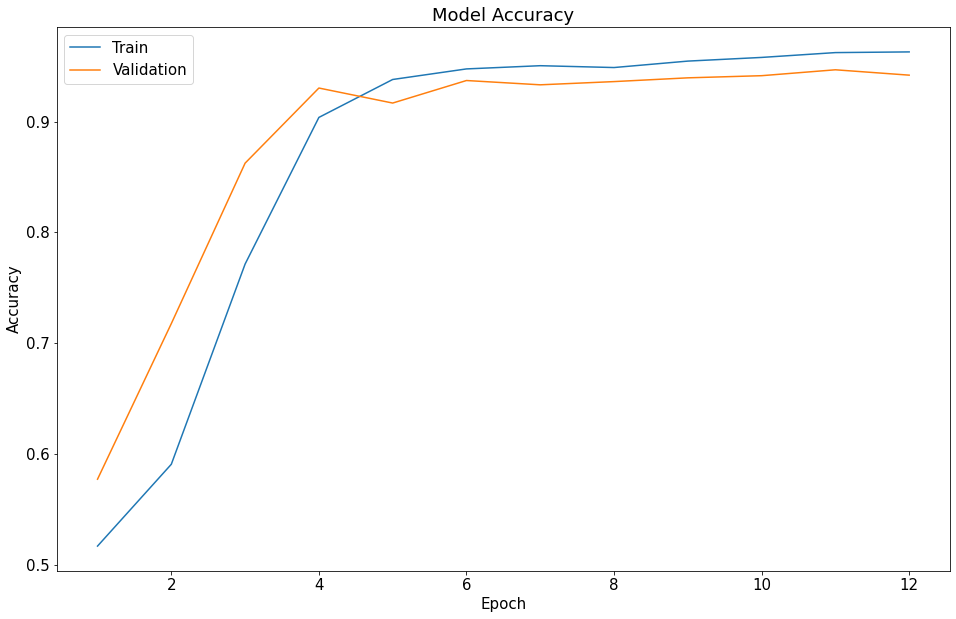

In [17]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams.update({'font.size': 15})

epochRange = range(1, 13)

plt.plot(epochRange, history.history['accuracy'])
plt.plot(epochRange, history.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.legend(['Train', 'Validation'], loc='upper left')

<a id='Part_2-Step_4-Model_Loss'></a>
### Model Loss

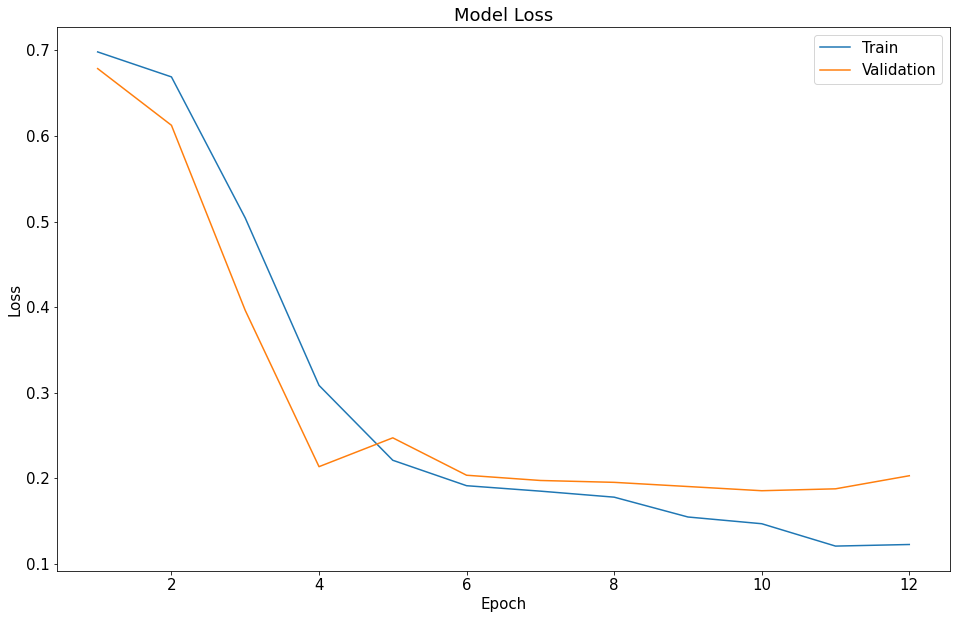

In [18]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams.update({'font.size': 15})

epochRange = range(1, 13)

plt.plot(epochRange, history.history['loss'])
plt.plot(epochRange, history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.legend(['Train', 'Validation'], loc='upper right')

<a id='Part_2-Step_5'></a>
## Step 5: Model Predictions

> **NOTE:** Change `split_cell_image_dir` to `cell_image_dir` if you skipped spitting the image folders

In [64]:
# If you get a "<None Type>" error relating to "image", 
# uncomment the below import and try again (seems to happen randomly)
# from tensorflow.keras.preprocessing import image

image_list = []

for fold in os.listdir(split_cell_image_dir):
    img_fold = os.path.join(split_cell_image_dir, fold)
    
    if 'Uninfected' in img_fold:
        img_class = 0
    else:
        # Parasitized
        img_class = 1
        
    image_list += [(str(os.path.join(img_fold, img)), img_class) for img in next(os.walk(img_fold))[2]]

# Shuffle list of images
random.shuffle(image_list)

# True cell classess
true_image_classes = [img_class[1] for img_class in image_list]
parsed_images = []

for img_path in image_list:
    img = image.load_img(img_path[0], target_size=(128, 128))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    parsed_images.append(img)

parsed_images = np.vstack(parsed_images)
preds = (model.predict(parsed_images, batch_size=10) > 0.5).astype("int32")

<a id='Part_2-Step_5-Conf_Mat'></a>
### Classification Confusion Matrix

Text(0, 0.5, 'Actual')

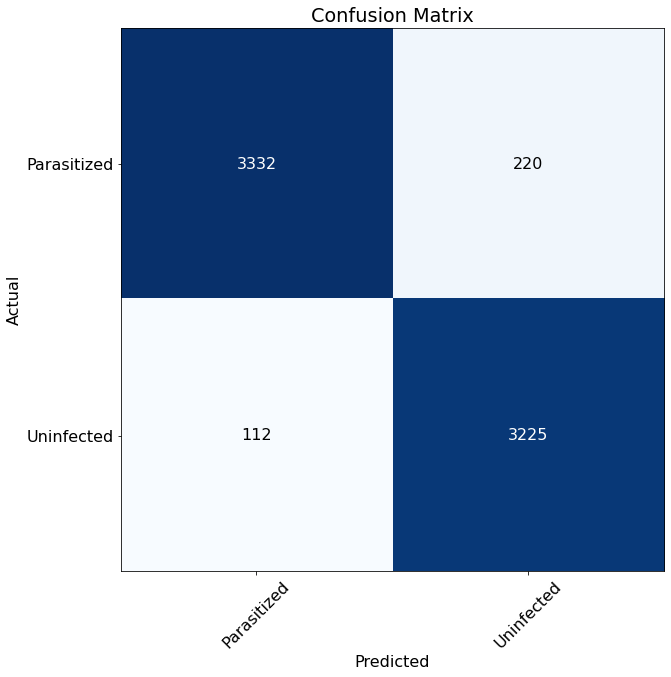

In [73]:
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams.update({'font.size': 16})

plot_confusion_matrix(conf_mat=confusion_matrix(preds, true_image_classes), 
                      class_names=['Parasitized', 'Uninfected'], cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

From the matrix above we can see that the model predictions were very good and made relatively few mistakes. The model incorrectly identified 220 Uninfected cells as Parasitized and 112 Parasitized cells as Uninfected.

<a id='Part_2-Step_6'></a>
## Step 6: Display Model Results

<a id='Part_2-Step_6-Class_Report'></a>
### Classification Report 

In [72]:
print(classification_report(true_image_classes, preds, target_names=['Uninfected', 'Parasitized']))

              precision    recall  f1-score   support

  Uninfected       0.94      0.97      0.95      3444
 Parasitized       0.97      0.94      0.95      3445

    accuracy                           0.95      6889
   macro avg       0.95      0.95      0.95      6889
weighted avg       0.95      0.95      0.95      6889



<a id='Part_2-Step_6-Results_Samp'></a>
### Prediction Results Sample

Lets predict on the same sample of images that were randomly selected for display from the dataset in [Step 1 - Display Augmented Images](#Part_2-Step_1-Aug_Images)

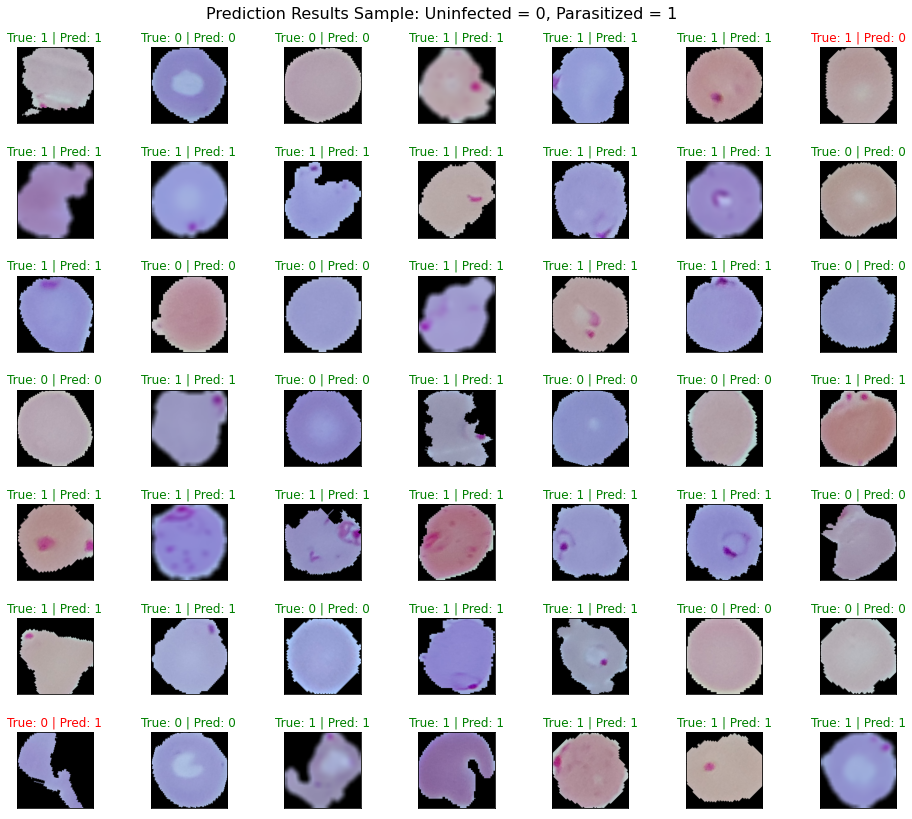

In [100]:
plt.rcParams['figure.figsize'] = (16, 14)
plt.rcParams.update({'font.size': 10})

for i, rand_val in enumerate(zip(rand_cells, rand_labels)):
    pred = (model.predict(cells[[rand_val[0]]], batch_size=10) > 0.5).astype("int32")
    
    plt.subplot(7, 7, i + 1)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    
    plt.imshow(cells[rand_val[0]])
    
    if rand_val[1] != pred[0][0]:
        col = 'red'
    else:
        col = 'green'
        
    plt.title('True: {} | Pred: {}'.format(rand_val[1], pred[0][0]), fontdict={'color': col})
    
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Prediction Results Sample: Uninfected = 0, Parasitized = 1', fontsize=16, y=0.92)
plt.show()

<a id='Part_2-Conclusion'></a>
## Part 2 Conclusion

See [Part 1 Conclusion](#Part_1-Conclusion) for FastAi results.

Again, even with the severely reduced number of images for training, the model performed very well with an accuracy score of `~0.96`. The `Tensorflow/Keras` modeling (about 1.5 hrs) took about half as long as the `FastAI` modeling (about 3 hrs) to complete, which is a great improvement in that regard. In terms of model performance, the keras model performed just slight better than the fastai model (`~0.94`). Given that they are so close to each other, I'm willing to chalk it up to margin of error and say that they perform about the same. As a result, this leaves the model training time as the deciding factor for the better model.

Both of these CNN model implementations have their pros and cons, fastai makes it very simple to create, run, sample, and predict with very little extra work on the users part. The drawback to this is that you don't have as much finer control of your model and largely left to the whims of the library. Tensorflow/Keras however, provides much finer control over pretty much all aspects of the modeling process but at the cost of having to create it all yourself, thus longer time for development. It's hard to say which of these models is better but I think it largely depends on the project constraints and how much time you are willing to spend on it.

<ins>My opinion is:</ins>
* If you just want to get to the modeling with minimal fuss/building and have most everything built-in for you, I would recommend using `FastAI`. 
* If you want to build everything yourself and have much finer control over your modeling, I would recommend using `Tensorflow/Keras`.

In either case, I can't recommend enough how much better your modeling life will be with a better GPU and [CUDA](https://developer.nvidia.com/cuda-toolkit), especially so if you are doing image processing.